# RNN prediction for Bitcoin value
From our processed data mart we are using a specific view for Bitcoin data and performing time series prediction using RNN method. Recurrant Neural Networks are used to handle sequence dependance and can be used for time series       prediction. In this analysis method we are using Keras deep learning library to demonstrate time series prediction.

*** We are using Keras and Tensorflow for our LSTM-RNN forecasting.
We recommend running this notebook on Google Colab or Tensorflow compatible
systems

In [1]:
# Importing Libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy

In [2]:
#Using data from AWS RDS which is the data warehouse
username = "postgres"
password = "postgres"
endpoint = "crypto-warehouse.cdvabacdldda.us-west-1.rds.amazonaws.com" 
dbname   = "BitcoinDataMart"

con = sqlalchemy.create_engine("postgresql://%s:%s@%s/%s" % (username, password, endpoint, dbname))

df = pd.read_sql("SELECT \"unix\", \"Open\", \"high\", \"low\", \"Close\", \"volume-coin\", \"volume-usd\",\
                 \"date\", \"just_date\", \"just_time\"\
                 FROM bitcoin_datamart_data", con)
#print(pd.__version__)
df.head()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,unix,Open,high,low,Close,volume-coin,volume-usd,date,just_date,just_time
0,1475279880,608.23,608.23,608.23,608.23,0.133542,81.22409,2016-09-30 23:58:00,2016-09-30,23:58:00
1,1475279940,608.23,608.23,608.23,608.23,0.819249,498.29156,2016-09-30 23:59:00,2016-09-30,23:59:00
2,1475280060,608.23,608.25,608.23,608.25,2.390576,1454.03580,2016-10-01 00:01:00,2016-10-01,00:01:00
3,1475280120,608.39,608.47,608.39,608.47,1.384715,842.45465,2016-10-01 00:02:00,2016-10-01,00:02:00
4,1475280180,608.81,608.81,608.81,608.81,0.063840,38.86673,2016-10-01 00:03:00,2016-10-01,00:03:00


In [3]:
#Data Cleaning
#Although we have cleaned the data in Spark, but still for safety we will check and clean again
#Finding Null Values
df.isna().sum()

unix           0
Open           0
high           0
low            0
Close          0
volume-coin    0
volume-usd     0
date           0
just_date      0
just_time      0
dtype: int64

In [4]:
#Replacing NA for all the above columns with the mean value grouped by that day
df['Open'] = df['Open'].fillna(df.groupby('date')['Open'].transform('mean'))
df['high'] = df['high'].fillna(df.groupby('date')['high'].transform('mean'))
df['low'] = df['low'].fillna(df.groupby('date')['low'].transform('mean'))
df['Close'] = df['Close'].fillna(df.groupby('date')['Close'].transform('mean'))
df['volume-usd'] = df['volume-usd'].fillna(df.groupby('date')['volume-usd'].transform('mean'))


In [5]:
#Checking the results
df.isna().sum()

unix           0
Open           0
high           0
low            0
Close          0
volume-coin    0
volume-usd     0
date           0
just_date      0
just_time      0
dtype: int64

In [6]:
#If incase we still have na values that means that we have null values for all values of that day.
#Thus it makes sense to drop them since they will harm our models accuracy
df = df.dropna()

In [7]:
#Rechecking
df.isna().sum()

unix           0
Open           0
high           0
low            0
Close          0
volume-coin    0
volume-usd     0
date           0
just_date      0
just_time      0
dtype: int64

In [8]:
# Changing date and time values from epoch time to datetime.
# df['weighted_price'] = df['weighted_price'].astype(float)

# Pulled and processed dataset may not have weighted average values, so here I am calculating the weighed average. This value us the average proce of the asset for a given peried weighted by volume.
#This value will be used for RNN prediction.

df['my_weighted_avg'] = df[['high','low','Close']].mean(axis=1)
df.head()
df['date'] = pd.to_datetime(df['unix'],unit='s').dt.date

group = df.groupby('date')

Real_Price = group['my_weighted_avg'].mean()




In [9]:
# split data for train and test
prediction_days = 30
df_train= Real_Price[:len(Real_Price)-prediction_days]
df_test= Real_Price[len(Real_Price)-prediction_days:]


In [10]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [11]:
# !pip3 install keras 
# !pip3 install tensorflow 

In [12]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling  RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
669/669 [==============================] - 2s 2ms/step - loss: 0.0215
Epoch 2/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0101
Epoch 3/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0075
Epoch 4/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0050
Epoch 5/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 6/100
669/669 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 7/100
669/669 [==============================] - 1s 2ms/step - loss: 4.7794e-04
Epoch 8/100
669/669 [==============================] - 1s 2ms/step - loss: 1.8402e-04
Epoch 9/100
669/669 [==============================] - 1s 2ms/step - loss: 1.1802e-04
Epoch 10/100
669/669 [==============================] - 1s 2ms/step - loss: 1.0617e-04
Epoch 11/100
669/669 [==============================] - 1s 2ms/step - loss: 1.0094e-04
Epoch 12/100
669/669 [==============================] - 1s 2ms/step - loss: 

In [13]:
# Making predictions for BTC
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)



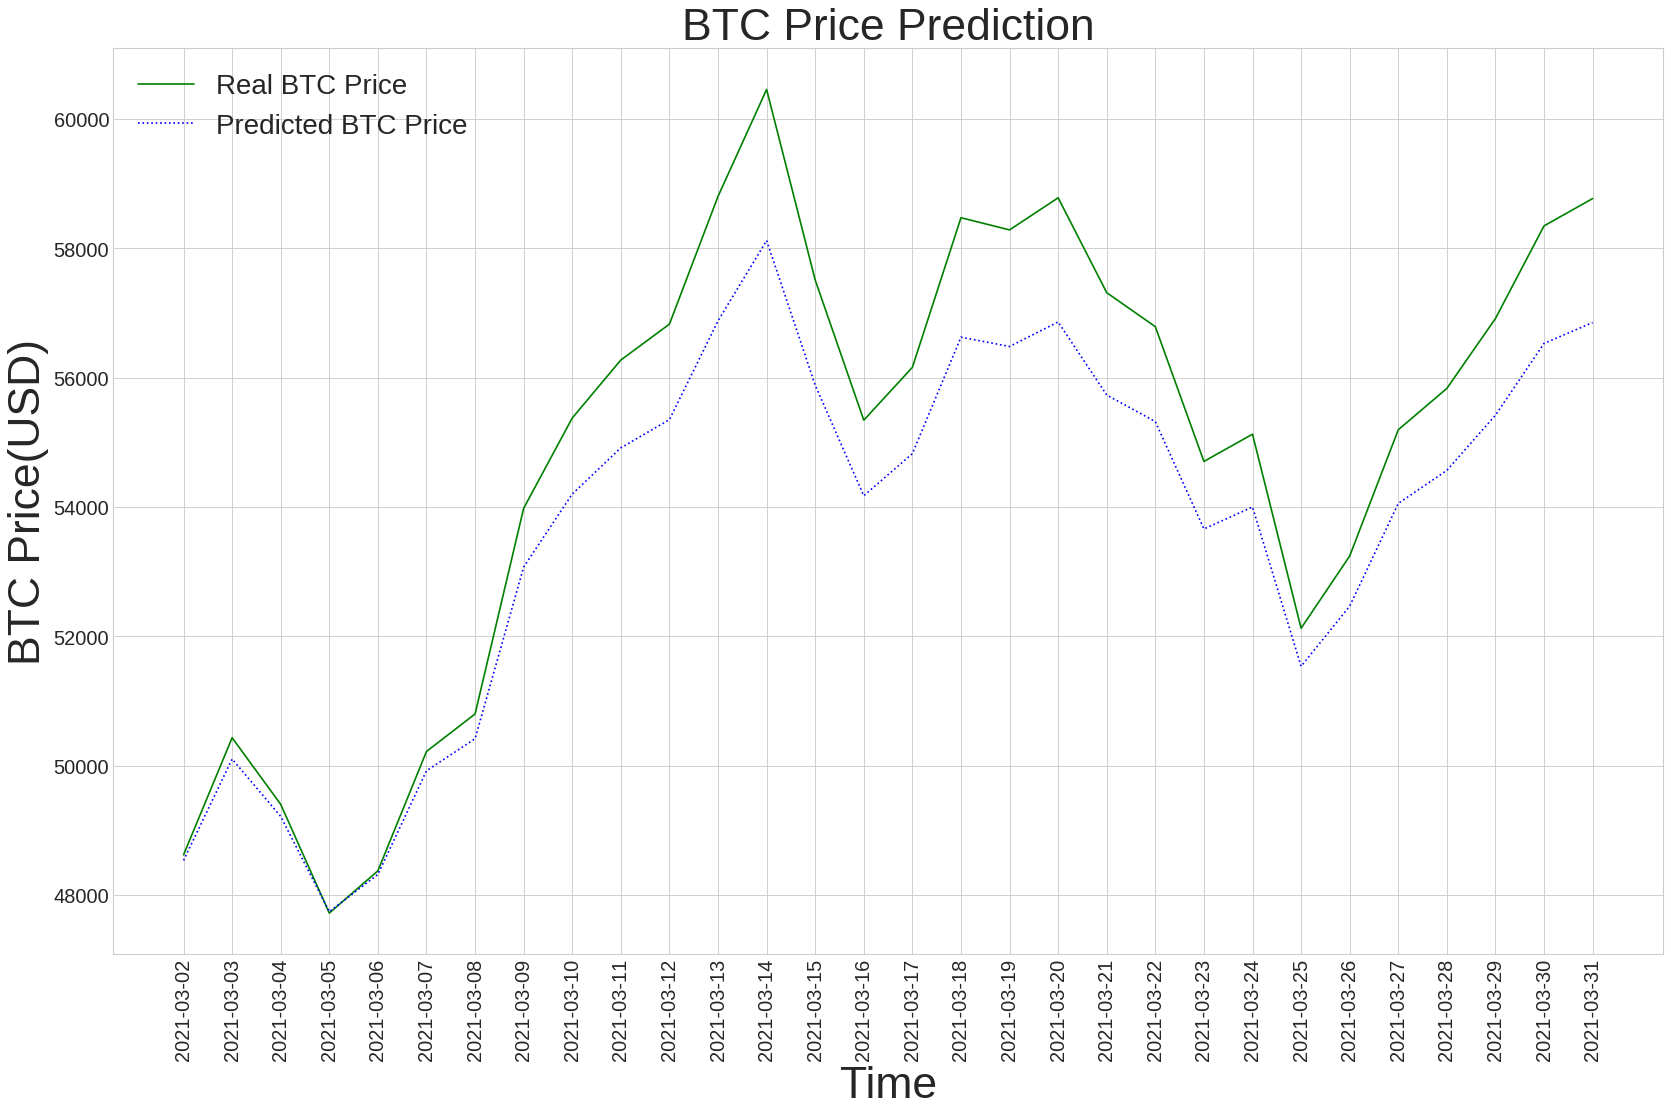

In [14]:

# Visualising the results
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set,'-g', label = 'Real BTC Price')
plt.plot(predicted_BTC_price,':b', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()



Bitcoin value is predicted for the last 30 days and we see that prediction is colse to the actual values.
